<a href="https://colab.research.google.com/github/pratheeksha-maddi/Book-recommendation-system-2021/blob/main/Book_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages, read datasets

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime   #yes

import warnings
warnings.filterwarnings('ignore')

In [ ]:
url_books = 'https://raw.githubusercontent.com/sruja08/book_recom_dataset/main/books.csv'
url_ratings = 'https://raw.githubusercontent.com/sruja08/book_recom_dataset/main/ratings.csv'
url_book_tags = 'https://raw.githubusercontent.com/sruja08/book_recom_dataset/main/book_tags.csv'
url_tags = 'https://raw.githubusercontent.com/sruja08/book_recom_dataset/main/tags.csv'


Overview of Dataset


In [ ]:
books = pd.read_csv(url_books)
ratings = pd.read_csv(url_ratings)
book_tags = pd.read_csv(url_book_tags)
tags = pd.read_csv(url_tags)

In [ ]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


BOOKS


In [ ]:
books.shape

(10000, 23)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [ ]:
pip install surprise

     |████████████████████████████████| 11.8MB 252kB/s 


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Data cleaning

In [ ]:
books['original_publication_year'] = books['original_publication_year'].fillna(-1).apply(lambda x: int(x) if x != -1 else -1)

In [ ]:
ratings_rmv_duplicates = ratings.drop_duplicates()
unwanted_users = ratings_rmv_duplicates.groupby('user_id')['user_id'].count()
unwanted_users = unwanted_users[unwanted_users < 3]
unwanted_ratings = ratings_rmv_duplicates[ratings_rmv_duplicates.user_id.isin(unwanted_users.index)]
new_ratings = ratings_rmv_duplicates.drop(unwanted_ratings.index)

In [ ]:
new_ratings['title'] = books.set_index('id').title.loc[new_ratings.book_id].values
new_ratings.head(10)

DATA Analysis


In [ ]:
def plot_books_by(df, col, n_rows=10):
    plt.figure(figsize=(12,7))
    ax = sns.barplot(x=df[col].head(n_rows), y=df['title'].head(n_rows), data=df)
    plt.title('Best ' + str(n_rows) + ' books by ' + col.replace('_',' ').capitalize(), weight='bold')
    plt.xlabel('Score of ' + col)
    plt.ylabel('Book Title')

In [ ]:
important_columns = ['title','authors','average_rating','ratings_count','work_text_reviews_count']

In [ ]:
#Top Rated Books
book_sorted_ratings = books[books['ratings_count']>=1000].sort_values('average_rating', ascending=False)
book_sorted_ratings[important_columns].head(5)

In [ ]:
plot_books_by(book_sorted_ratings, 'average_rating', 10)

In [ ]:
#Top Popular Books
book_sorted_ratings_count = books.sort_values('ratings_count', ascending=False)
book_sorted_ratings_count[important_columns].head(10)

In [ ]:
plot_books_by(book_sorted_ratings_count, 'ratings_count', 15)

In [ ]:
#Top Text-Reviewed Books
book_sorted_reviews_count = books[books['ratings_count']>=1000].sort_values('work_text_reviews_count', ascending=False)
book_sorted_reviews_count[important_columns].head()

In [ ]:
plot_books_by(book_sorted_reviews_count, 'work_text_reviews_count', 5)

In [ ]:
#Top Scored Books
from sklearn.preprocessing import MinMaxScaler

In [ ]:
cols = ['ratings_count','average_rating']
scaler = MinMaxScaler()
df_normalized = books[important_columns].copy()
df_normalized[cols] = scaler.fit_transform(df_normalized[cols])

In [ ]:
df_normalized.head()

In [ ]:
df_normalized['book_score'] = 0.5 * df_normalized['ratings_count'] + 0.5 * df_normalized['average_rating']

In [ ]:
df_normalized_sorted_score = df_normalized.sort_values('book_score', ascending=False)
df_normalized_sorted_score.head()

In [ ]:
plot_books_by(df_normalized_sorted_score, 'book_score', 7)

In [ ]:
#language
lang_counts = pd.DataFrame(books['language_code'].value_counts())
lang_counts.columns = ['counts']
lang_counts

In [ ]:
len(lang_counts)

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Number of Books released in a specific Language (English included).", weight='bold')
plt.bar(x=lang_counts.index,height='counts', data=lang_counts);

In [ ]:
lang_counts = lang_counts.drop(["en-US", "en-GB", "eng", "en-CA"])

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Number of Books released in a specific Language (English excluded).", weight='bold')
plt.bar(x=lang_counts.index,height='counts', data=lang_counts);

In [ ]:
#Date and year
books['original_publication_year'] = books['original_publication_year'].astype(int)
year_count = books.groupby('original_publication_year')['title'].count()
plt.figure(figsize=(18,5))
year_count.plot();

In [ ]:
plt.figure(figsize=(18,5))
year_count[year_count.index > 1900].plot();

In [ ]:
books.groupby('original_publication_year')['title'].count()[books.groupby('original_publication_year')['title'].count()>200]

In [ ]:
books[['title', 'original_publication_year']].sort_values('original_publication_year').head(10)

In [ ]:
books[['book_id', 'title', 'original_publication_year']].sort_values('original_publication_year').tail(10)

In [ ]:
#Authors
books.authors.value_counts()

In [ ]:
#Multiple authors
a = []
books.authors.apply(lambda x: a.append(x) if ',' in x else [])
a[:10]

In [ ]:
print('Number of books with multi-authors is {}.'.format(len(a)))

In [ ]:
authors_list = books['authors'].apply(lambda x: [a for a in x.split(', ')] if ',' in x else x)
authors_list.head()

In [ ]:
authors_list.head(6).apply(lambda x: pd.Series(x)).stack().head(6)

In [ ]:
authors_list.head(6).apply(lambda x: pd.Series(x)).stack().head(6).reset_index(level=1, drop=True)

In [ ]:
#For multi-authors books, we will split their authors with a copy of the book for each one.
splitted_authors = authors_list.apply(lambda x: pd.Series(x)).stack().reset_index(level=1, drop=True)
splitted_authors.name = 'authors'
splitted_authors.head()

In [ ]:
df_edited_authors = books[important_columns].drop('authors', axis=1).join(splitted_authors)
df_edited_authors.head()

In [ ]:
books.shape, df_edited_authors.shape

In [ ]:
df_edited_authors.authors.value_counts()

We can see now the difference as the previous largest number of books was 60 for Stephen King, now it's 98 for James Patterson.



In [ ]:
def plot_authors_by(df, title, xlabel, n=15, ylabel='Author', y_size=7):
    plt.figure(figsize=(15,y_size))
    ax = sns.barplot(x=df.head(n).values, y=df.head(n).index)
    plt.title(title, weight='bold')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [ ]:
authors_most_with_books = df_edited_authors.authors.value_counts()
authors_most_with_books.head(15)

In [ ]:
plot_authors_by(authors_most_with_books, 'Authors with most books', 'Number of Books', 10)


In [ ]:
#For coming analysis we need to filter authors by their number of books & total ratings count, as for an author (with just one book and few ratings of 5),
# won't be the same for a popular author with avrage-rating of maybe 4.5.
def at_least_books(df, n):
    more_than_n = df_edited_authors['authors'].value_counts().values >= n
    return df['authors'].isin(df['authors'].value_counts()[more_than_n == True].index)

In [ ]:
def at_least_ratings_count(df, n):
    return df.ratings_count >= n

In [ ]:
at_least_books(df_edited_authors, 5).head()

In [ ]:
at_least_ratings_count(df_edited_authors, 10000).head()

In [ ]:
df_edited_authors['authors'].value_counts().describe()

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_edited_authors.authors.value_counts().values);
plt.xlabel('number of books');
plt.ylabel('count');

In [ ]:
df_edited_authors['ratings_count'].describe()

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(df_edited_authors['ratings_count']);
plt.xlabel('number of ratings');
plt.ylabel('count');

In [ ]:
#we have chosen at least 5 books and 50k ratings for a successful author.
c1 = at_least_books(df_edited_authors, 5)
c2 = at_least_ratings_count(df_edited_authors, 50000)

In [ ]:
c1.head()

In [ ]:
best_rating_authors = df_edited_authors[c1 & c2].groupby('authors')['average_rating'].mean().sort_values(ascending=False)
best_rating_authors.head(5)

In [ ]:
print('Best Rating Authors are {} of {} authors'.format(len(best_rating_authors),len(df_edited_authors.authors.unique())))

In [ ]:
plot_authors_by(best_rating_authors, 'Best Rating Authors', 'Rating', 10)

In [ ]:
#Most ratings authors
most_ratings_authors = df_edited_authors.groupby('authors')['ratings_count'].sum().sort_values(ascending=False)
most_ratings_authors.head()

In [ ]:
plot_authors_by(most_ratings_authors, 'Most Ratings Authors', 'Total Ratings', 15)

In [ ]:
#Best Authors
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
best_rating_authors_normalized = pd.DataFrame(best_rating_authors.values, index=best_rating_authors.index, columns=['rating'])
best_rating_authors_normalized['rating'] = scaler.fit_transform(best_rating_authors_normalized)
best_rating_authors_normalized.head()

In [ ]:
authors_rating_score = df_edited_authors['authors'].apply(lambda x: best_rating_authors_normalized.loc[x].rating if x in best_rating_authors_normalized.index else 0.0)
authors_rating_score.head()

In [ ]:
most_ratings_authors_normalized = pd.DataFrame(most_ratings_authors.values, index=most_ratings_authors.index, columns=['total_rating'])
most_ratings_authors_normalized['total_rating'] = scaler.fit_transform(most_ratings_authors_normalized)
most_ratings_authors_normalized.head()

In [ ]:
authors_ratings_count_score = df_edited_authors['authors'].apply(lambda x: most_ratings_authors_normalized.loc[x].total_rating)
authors_ratings_count_score.head()

0    0.506137
1    1.000000
1    0.890216
2    0.500477
3    0.195261
Name: authors, dtype: float64

In [ ]:
df_edited_authors['author_score'] = 0.5 * authors_rating_score + 0.5 * authors_ratings_count_score
df_edited_authors['author_score'].head()

0    0.612224
1    0.848151
1    0.898327
2    0.452116
3    0.097631
Name: author_score, dtype: float64

In [ ]:
best_authors = df_edited_authors.groupby('authors')['author_score'].mean().sort_values(ascending=False)
best_authors.head(10)

authors
Mary GrandPré         0.898327
J.K. Rowling          0.848151
Suzanne Collins       0.612224
J.R.R. Tolkien        0.553017
Cassandra Clare       0.535041
Rick Riordan          0.532272
Stephen King          0.525440
George R.R. Martin    0.517450
Bill Watterson        0.512536
Sarah J. Maas         0.487520
Name: author_score, dtype: float64

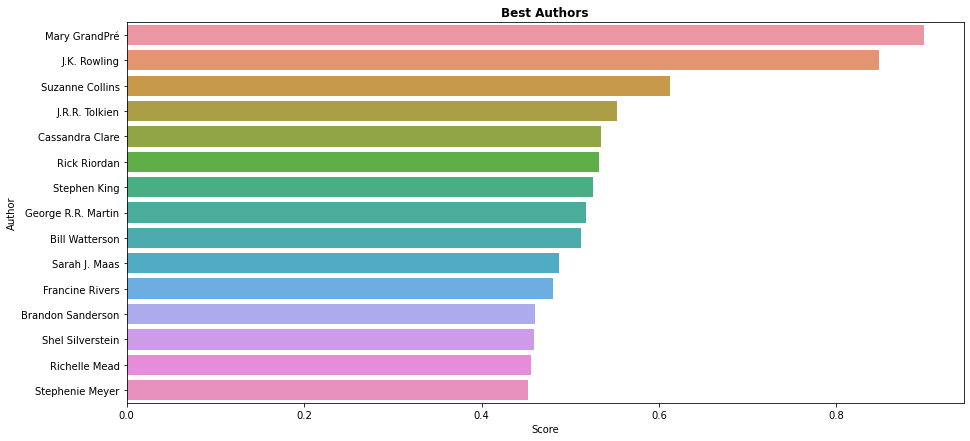

In [ ]:
plot_authors_by(best_authors, 'Best Authors', 'Score', 15)

In [ ]:
#Ratings
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
print('There are {} ratings.'.format(ratings.shape[0]))

There are 981756 ratings.


In [ ]:
print('Number of users is {}'.format(len(ratings.user_id.unique())))

Number of users is 53424


In [ ]:
#Remove duplicate ratings
ratings[ratings.duplicated()==True]


,book_id,user_id,rating
1171,12,40251,4
2474,25,32635,5
2959,30,31760,4
3020,31,8669,5
3334,34,26097,1
...,...,...,...
979373,9975,3133,3
980520,9988,907,4
981044,9993,33994,4
981257,9995,28898,2


In [ ]:
ratings[ratings.duplicated(keep=False)==True].head(6)

,book_id,user_id,rating
1170,12,40251,4
1171,12,40251,4
2473,25,32635,5
2474,25,32635,5
2958,30,31760,4
2959,30,31760,4


In [ ]:
ratings_rmv_duplicates = ratings.drop_duplicates()
ratings_rmv_duplicates.shape

(980112, 3)

In [ ]:
ratings_sample = ratings_rmv_duplicates.sample(frac=0.2)
ratings_sample.shape

(196022, 3)

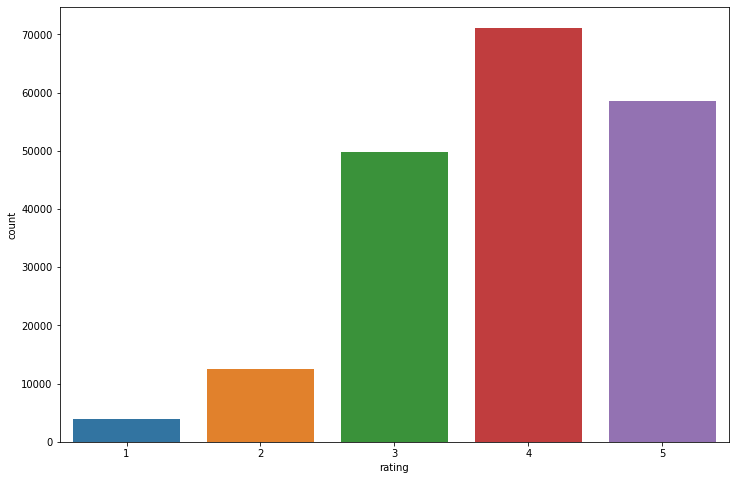

In [ ]:
#Distribution of ratings
plt.figure(figsize=(12,8))
sns.countplot(x='rating', data=ratings_sample);

In [ ]:
ratings_per_user = ratings_sample.groupby('user_id')['user_id'].count()
ratings_per_user

user_id
2        1
3        1
4        2
5        2
6        1
        ..
53417    1
53420    2
53421    1
53422    4
53424    5
Name: user_id, Length: 40568, dtype: int64

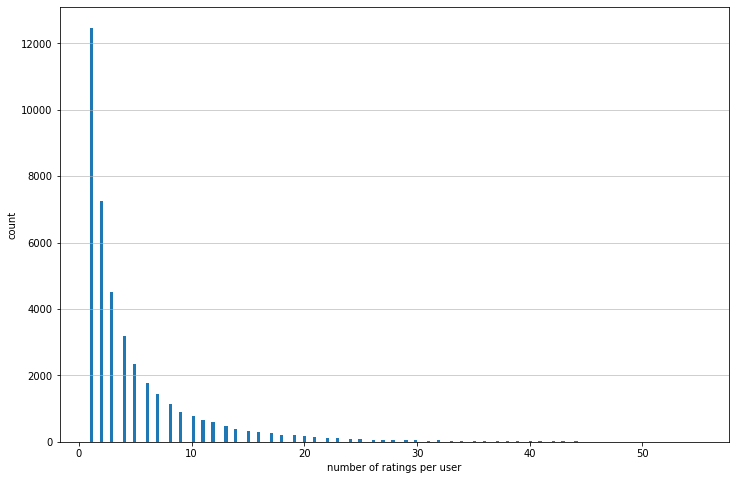

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(ratings_per_user ,bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('number of ratings per user')
plt.ylabel('count');

In [ ]:
mean_rating_per_user = ratings_sample.groupby('user_id')['rating'].mean()
mean_rating_per_user

user_id
2        4.00
3        1.00
4        5.00
5        4.50
6        5.00
         ... 
53417    4.00
53420    3.50
53421    5.00
53422    3.75
53424    4.20
Name: rating, Length: 40568, dtype: float64

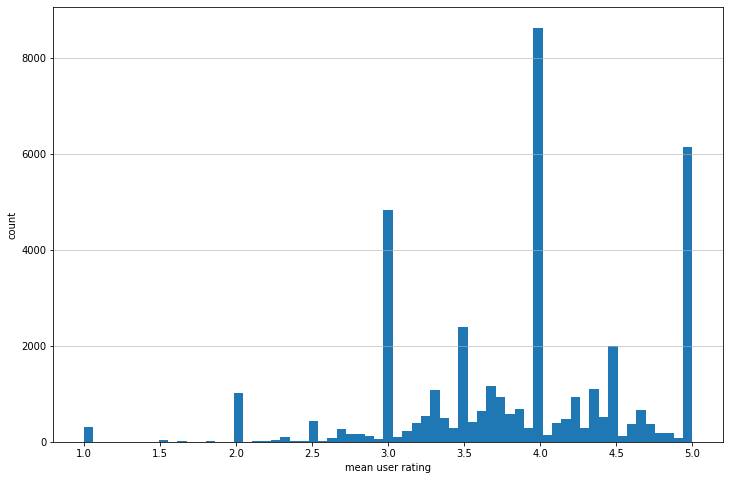

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(mean_rating_per_user, bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mean user rating')
plt.ylabel('count');

In [ ]:
ratings_per_book = ratings_sample.groupby('book_id')['book_id'].count()
ratings_per_book

book_id
1        24
2        25
3        18
4        21
5        20
         ..
9996     26
9997     19
9998     19
9999     21
10000    22
Name: book_id, Length: 10000, dtype: int64

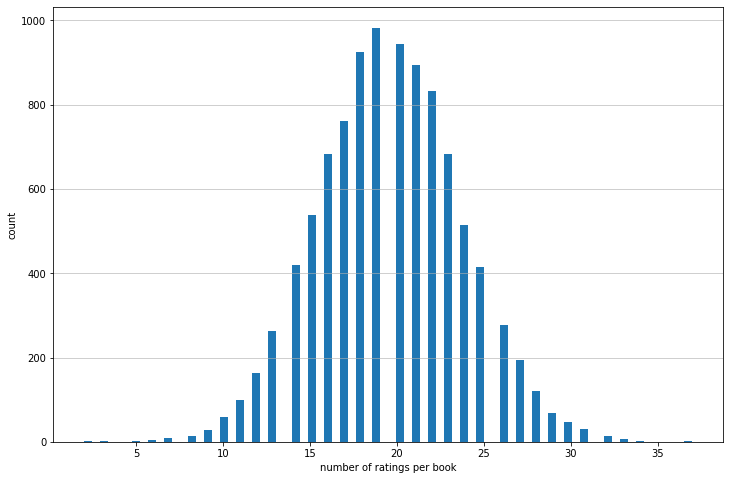

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(ratings_per_book ,bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('number of ratings per book')
plt.ylabel('count');

In [ ]:
mean_rating_per_book = ratings_sample.groupby('book_id')['rating'].mean()
mean_rating_per_book

book_id
1        3.791667
2        4.160000
3        3.000000
4        4.380952
5        3.800000
           ...   
9996     4.038462
9997     4.210526
9998     3.789474
9999     3.619048
10000    4.045455
Name: rating, Length: 10000, dtype: float64

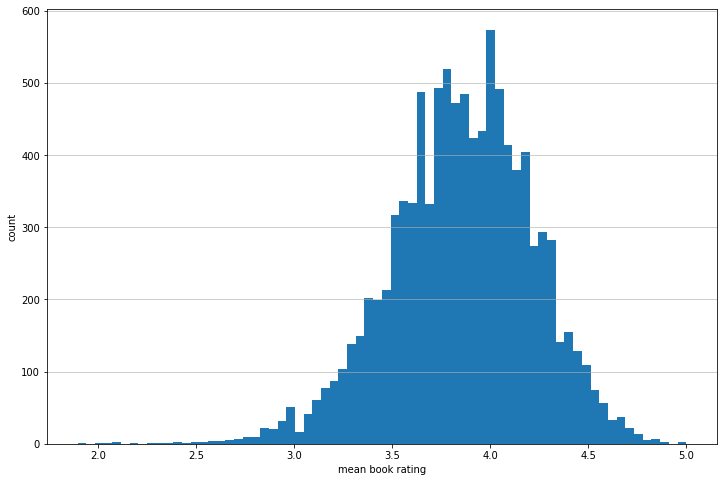

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(mean_rating_per_book, bins='auto');
plt.grid(axis='y', alpha=0.75)
plt.xlabel('mean book rating')
plt.ylabel('count');

In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
print(book_tags.shape)
book_tags.head()

(999912, 3)


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
genres = ["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics",
          "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction",
          "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror",
          "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal",
          "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction",
          "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]

In [ ]:
genres = list(map(str.lower, genres))
genres[:4]

['art', 'biography', 'business', 'chick lit']

In [ ]:
available_genres = tags.loc[tags.tag_name.str.lower().isin(genres)]

In [ ]:
print('Number of available tags is {} out of the {} tags in genres list'.format(available_genres.shape[0], len(genres)))

Number of available tags is 31 out of the 40 tags in genres list


In [ ]:
available_books_with_genres = book_tags[book_tags.tag_id.isin(available_genres.tag_id)]
available_books_with_genres.shape

(60573, 3)

In [ ]:
tag_counts = pd.DataFrame(available_books_with_genres.groupby('tag_id')['count'].sum())
tag_counts.head()

,count
tag_id,
2938,30262
4605,172444
5951,73249
7077,53864
7457,1756920


In [ ]:
tag_counts.set_index(available_genres.tag_name, inplace=True)
tag_counts.head()

,count
tag_name,
art,30262
biography,172444
business,73249
christian,53864
classics,1756920


In [ ]:
tag_counts.sort_values('count', ascending=False, inplace=True)
tag_counts.head()

,count
tag_name,
fiction,3688819
fantasy,3548157
classics,1756920
romance,1231926
mystery,872282


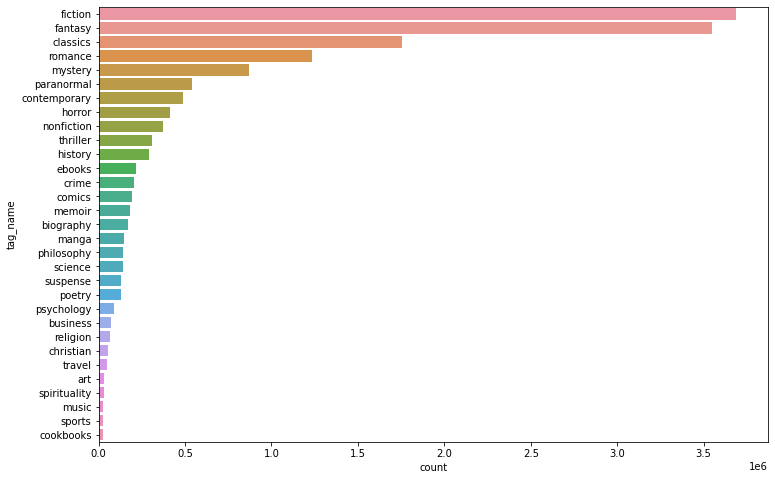

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x='count', y=tag_counts.index, data=tag_counts, orient='h');

In [ ]:
#Series of books
subtitle = 'the lord of the rings'
books[books.title.str.lower().str.find(subtitle) > -1][['title']].values

array([['The Fellowship of the Ring (The Lord of the Rings, #1)'],
       ['The Two Towers (The Lord of the Rings, #2)'],
       ['The Return of the King (The Lord of the Rings, #3)'],
       ['The Lord of the Rings (The Lord of the Rings, #1-3)'],
       ['J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings'],
       ['The Lord of the Rings: The Art of The Fellowship of the Ring'],
       ['The Lord of the Rings: Weapons and Warfare'],
       ['The Lord of the Rings: The Return of the King: Visual Companion'],
       ['The Lord of the Rings Sketchbook']], dtype=object)

In [ ]:
book_series = books[books.title.str.contains('\(.*[,:]') == True][['title', 'average_rating']]

In [ ]:
print('There are {} books that are in series'.format(book_series.shape[0]))


There are 4171 books that are in series


In [ ]:
book_series.head()

,title,average_rating
0,"The Hunger Games (The Hunger Games, #1)",4.34
1,Harry Potter and the Sorcerer's Stone (Harry P...,4.44
2,"Twilight (Twilight, #1)",3.57
8,"Angels & Demons (Robert Langdon, #1)",3.85
11,"Divergent (Divergent, #1)",4.24


In [ ]:
series = book_series.copy()
series['title'] = series['title'].str.findall('\(.*[,:]').apply(lambda x: x.pop()[1:-1])
series.head()

,title,average_rating
0,The Hunger Games,4.34
1,Harry Potter,4.44
2,Twilight,3.57
8,Robert Langdon,3.85
11,Divergent,4.24


In [ ]:
#Correlation
cols = ['books_count','original_publication_year','average_rating','ratings_count','work_ratings_count','work_text_reviews_count']

In [ ]:
corr = books[cols].corr()
corr

,books_count,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count
books_count,1.000000,-0.269374,-0.069888,0.324235,0.333664,0.198698
original_publication_year,-0.269374,1.000000,-0.000429,-0.017774,-0.018123,0.033506
average_rating,-0.069888,-0.000429,1.000000,0.044990,0.045042,0.007481
ratings_count,0.324235,-0.017774,0.044990,1.000000,0.995068,0.779635
work_ratings_count,0.333664,-0.018123,0.045042,0.995068,1.000000,0.807009
work_text_reviews_count,0.198698,0.033506,0.007481,0.779635,0.807009,1.000000


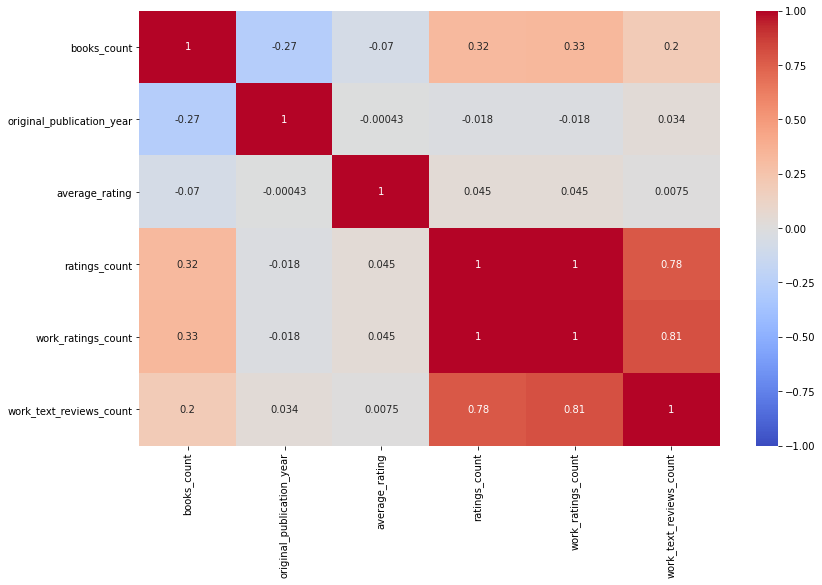

In [ ]:
plt.figure(figsize=(13,8))
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot=True);

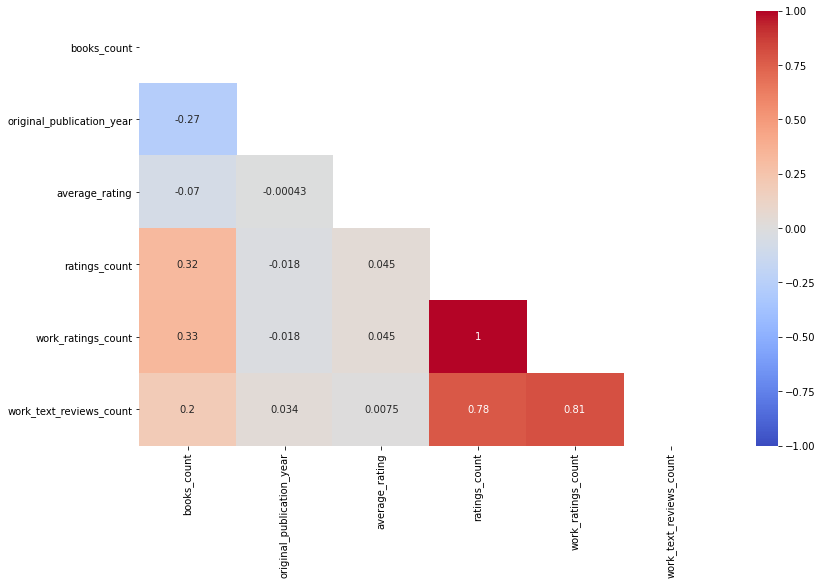

In [ ]:
#Removing the Duplicate Top-Half
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(13,8))
sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, mask = mask);

# Simple recommender

In [ ]:
v = books['ratings_count']
m = books['ratings_count'].quantile(0.95)
R = books['average_rating']
C = books['average_rating'].mean()
W = (R*v + C*m) / (v + m)

In [ ]:
books['weighted_rating'] = W

In [ ]:
qualified  = books.sort_values('weighted_rating', ascending=False).head(250)

In [ ]:
qualified[['title', 'authors', 'average_rating', 'weighted_rating']].head(15)


,title,authors,average_rating,weighted_rating
24,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",4.61,4.555956
26,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",4.54,4.490428
17,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",4.53,4.485090
23,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",4.53,4.483227
1,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",4.44,4.424365
20,Harry Potter and the Order of the Phoenix (Har...,"J.K. Rowling, Mary GrandPré",4.46,4.419054
30,The Help,Kathryn Stockett,4.45,4.405158
38,"A Game of Thrones (A Song of Ice and Fire, #1)",George R.R. Martin,4.45,4.398759
134,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,4.54,4.396645
421,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,4.74,4.391147


# Top "Genres" Books

In [ ]:
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
genres = ["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics",
          "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction",
          "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror",
          "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal",
          "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction",
          "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]

In [ ]:
genres = list(map(str.lower, genres))
genres[:4]

['art', 'biography', 'business', 'chick lit']

In [ ]:
available_genres = tags.loc[tags.tag_name.str.lower().isin(genres)]
available_genres.head()

,tag_id,tag_name
2938,2938,art
4605,4605,biography
5951,5951,business
7077,7077,christian
7457,7457,classics


In [ ]:
available_genres_books = book_tags[book_tags.tag_id.isin(available_genres.tag_id)]

In [ ]:
print('There are {} books that are tagged with above genres'.format(available_genres_books.shape[0]))

There are 60573 books that are tagged with above genres


In [ ]:
available_genres_books.head()

,goodreads_book_id,tag_id,count
1,1,11305,37174
5,1,11743,9954
25,1,7457,958
38,1,22973,673
52,1,20939,465


In [ ]:
available_genres_books['genre'] = available_genres.tag_name.loc[available_genres_books.tag_id].values
available_genres_books.head()

,goodreads_book_id,tag_id,count,genre
1,1,11305,37174,fantasy
5,1,11743,9954,fiction
25,1,7457,958,classics
38,1,22973,673,paranormal
52,1,20939,465,mystery


In [ ]:
def build_chart(genre, percentile=0.85):
    df = available_genres_books[available_genres_books['genre'] == genre.lower()]
    qualified = books.set_index('book_id').loc[df.goodreads_book_id]

    v = qualified['ratings_count']
    m = qualified['ratings_count'].quantile(percentile)
    R = qualified['average_rating']
    C = qualified['average_rating'].mean()
    qualified['weighted_rating'] = (R*v + C*m) / (v + m)

    qualified.sort_values('weighted_rating', ascending=False, inplace=True)
    return qualified

In [ ]:
cols = ['title','authors','original_publication_year','average_rating','ratings_count','work_text_reviews_count','weighted_rating']
genre = 'Fiction'

In [ ]:
build_chart(genre)[cols].head(10)

,title,authors,original_publication_year,average_rating,ratings_count,work_text_reviews_count,weighted_rating
book_id,,,,,,,
136251,Harry Potter and the Deathly Hallows (Harry Po...,"J.K. Rowling, Mary GrandPré",2007,4.61,1746574,51942,4.587098
862041,"Harry Potter Boxset (Harry Potter, #1-7)",J.K. Rowling,1998,4.74,190050,6508,4.544691
1,Harry Potter and the Half-Blood Prince (Harry ...,"J.K. Rowling, Mary GrandPré",2005,4.54,1678823,27520,4.518933
5,Harry Potter and the Prisoner of Azkaban (Harr...,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999,4.53,1832823,36099,4.510997
6,Harry Potter and the Goblet of Fire (Harry Pot...,"J.K. Rowling, Mary GrandPré",2000,4.53,1753043,31084,4.510164
62291,"A Storm of Swords (A Song of Ice and Fire, #3)",George R.R. Martin,2000,4.54,469022,19497,4.471466
186074,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss,2007,4.55,400101,28631,4.469922
1215032,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,2011,4.57,245686,15503,4.446163
18512,"The Return of the King (The Lord of the Rings,...",J.R.R. Tolkien,1955,4.51,463959,6644,4.444645


In [ ]:
list(enumerate(available_genres.tag_name))

[(0, 'art'),
 (1, 'biography'),
 (2, 'business'),
 (3, 'christian'),
 (4, 'classics'),
 (5, 'comics'),
 (6, 'contemporary'),
 (7, 'cookbooks'),
 (8, 'crime'),
 (9, 'ebooks'),
 (10, 'fantasy'),
 (11, 'fiction'),
 (12, 'history'),
 (13, 'horror'),
 (14, 'manga'),
 (15, 'memoir'),
 (16, 'music'),
 (17, 'mystery'),
 (18, 'nonfiction'),
 (19, 'paranormal'),
 (20, 'philosophy'),
 (21, 'poetry'),
 (22, 'psychology'),
 (23, 'religion'),
 (24, 'romance'),
 (25, 'science'),
 (26, 'spirituality'),
 (27, 'sports'),
 (28, 'suspense'),
 (29, 'thriller'),
 (30, 'travel')]

In [ ]:
idx = 5  # comic
build_chart(list(available_genres.tag_name)[idx])[cols].head(10)

,title,authors,original_publication_year,average_rating,ratings_count,work_text_reviews_count,weighted_rating
book_id,,,,,,,
43070,The Essential Calvin and Hobbes: A Calvin and ...,Bill Watterson,1988,4.65,93001,598,4.509084
77727,Calvin and Hobbes,"Bill Watterson, G.B. Trudeau",1987,4.61,117788,684,4.501512
24812,The Complete Calvin and Hobbes,Bill Watterson,2005,4.82,28900,861,4.451907
24813,The Calvin and Hobbes Tenth Anniversary Book,Bill Watterson,1995,4.63,48280,346,4.429600
659469,The Hobbit: Graphic Novel,"Chuck Dixon, J.R.R. Tolkien, David Wenzel, Sea...",1989,4.48,155338,957,4.420299
17131869,"Saga, Vol. 2 (Saga, #2)","Brian K. Vaughan, Fiona Staples",2013,4.57,56122,4594,4.411511
870,"Fullmetal Alchemist, Vol. 1 (Fullmetal Alchemi...","Hiromu Arakawa, Akira Watanabe",2002,4.49,93990,1103,4.400446
19358975,"Saga, Vol. 3 (Saga, #3)","Brian K. Vaughan, Fiona Staples",2014,4.56,47549,3506,4.391289
24814,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,1996,4.75,22351,264,4.391221


# Content Based Recommender

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [ ]:
books['authors'] = books['authors'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x.split(', ')])

In [ ]:
def get_genres(x):
    t = book_tags[book_tags.goodreads_book_id==x]
    return [i.lower().replace(" ", "") for i in tags.tag_name.loc[t.tag_id].values]

In [ ]:
books['genres'] = books.book_id.apply(get_genres)

In [ ]:
books['soup'] = books.apply(lambda x: ' '.join([x['title']] + x['authors'] + x['genres']), axis=1)

In [ ]:
books.soup.head()

In [ ]:
#books=books.head(1000)

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(books['soup'])

In [ ]:
# for c in count_matrix:
#     print(c)
#count_matrix=count_matrix.head(10000)
type(count_matrix)

# Cosine Similarity

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)
indices = pd.Series(books.index, index=books['title'])
titles = books['title']

In [ ]:
#cosine_sim

In [ ]:
def get_recommendations(title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    return list(titles.iloc[book_indices].values)[:n]

In [ ]:
get_recommendations("The One Minute Manager")

In [ ]:
#get_recommendations("The Mark of Athena (The Heroes of Olympus, #3)")

In [ ]:
#get_recommendations("The Nightingale")

In [ ]:
get_recommendations("Harry Potter Boxset (Harry Potter, #1-7)")

In [ ]:
def get_name_from_partial(title):
    return list(books.title[books.title.str.lower().str.contains(title) == True].values)

In [ ]:
title = "business" #Cold start
l = get_name_from_partial(title)
list(enumerate(l))

In [ ]:
# title = "tale"
# l = get_name_from_partial(title)
# list(enumerate(l))

In [ ]:
#l

In [ ]:
get_recommendations(l[1])

In [ ]:
def improved_recommendations(title, n=10):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    book_indices = [i[0] for i in sim_scores]
    df = books.iloc[book_indices][['title', 'ratings_count', 'average_rating', 'weighted_rating']]

    v = df['ratings_count']
    m = df['ratings_count'].quantile(0.60)
    R = df['average_rating']
    C = df['average_rating'].mean()
    df['weighted_rating'] = (R*v + C*m) / (v + m)

    qualified = df[df['ratings_count'] >= m]
    qualified = qualified.sort_values('weighted_rating', ascending=False)
    return qualified.head(n)

In [ ]:
improved_recommendations("The One Minute Manager")

In [ ]:
#improved_recommendations("The Nightingale")

In [ ]:
improved_recommendations(l[1])

# Collaborative Filtering

User Based

In [ ]:
ratings1 = pd.read_csv(url_ratings)
ratings1.head(5)
print(ratings.shape)

In [ ]:
n_users = ratings1.user_id.unique().shape[0]
n_books = ratings1.book_id.unique().shape[0]
print("The database contains ratings from", n_users, "users for", n_books, "books.")

In [ ]:
#Create user-book matrix of rating
data_matrix = np.zeros((n_users, n_books))
for line in ratings1.itertuples():
    data_matrix[line[2]-1, line[1]-1] = line[3]

In [ ]:
#Explore how many books a user rated
user_row = 314 # set user_id to explore here

In [ ]:
n_books_rated = 0
for book in range(0, n_books):
    if data_matrix[user_row, book] != 0:
        n_books_rated += 1
print(n_books_rated)

In [ ]:
#Calculate how many books all users rated
books_rated = np.zeros(n_users)
for user in range(0, n_users):
    books_rated[user] = np.count_nonzero(data_matrix[user])

In [ ]:
#plt.figure(figsize=(15,5))
plt.hist(books_rated, bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 60, 80, 100, 200])

Calculate cosine similarity between two users

In [ ]:
def cos_similar(u, v):
    return np.dot(u,v)/np.linalg.norm(u)/np.linalg.norm(v)

In [ ]:
cos_similar(data_matrix[2000], data_matrix[2000]) # similarity of itself

In [ ]:
cos_similar(data_matrix[2000], data_matrix[2001]) # similarity with other user

In [ ]:
#Find k most similar users for a given user
similar = np.zeros(n_users)
for user in range(0, n_users):
    similar[user] = cos_similar(data_matrix[user_row], data_matrix[user])

In [ ]:
print("This user read", np.count_nonzero(data_matrix[user_row]), "books.")
print("There are", np.count_nonzero(similar), "users that read at least one same book as this user.")

In [ ]:
#plt.figure(figsize=(15,5))
plt.hist(similar, bins = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1])

In [ ]:
top_similar = np.where(similar > 0.2)[0] # top similar users
print(top_similar)

In [ ]:
for user in top_similar:
    if user != user_row:
        print("Other similar users/recommenders read", np.count_nonzero(data_matrix[user]), "books.")

In [ ]:
#Avg rating among top users
books_rating = np.zeros(n_books)
for user in top_similar:
    books_rating += data_matrix[user]/len(top_similar)
plt.hist(books_rating, bins = [1,2,3,4,5,6])

In [ ]:
#Keeping highly rated books
best_book = np.where(books_rating == max(books_rating))[0][0]
print(best_book)

In [ ]:
good_book = np.where(books_rating > max(books_rating)/4)[0]
print(good_book, len(good_book))

In [ ]:
#Identify which book the user already read
read_book = np.where(data_matrix[user_row] != 0)[0]
print(read_book)

In [ ]:
books.head(1)

In [ ]:
print("The user rated the following books:")
books.loc[books['id'].isin(read_book)]

In [ ]:
books.loc[books['id'].isin(read_book)].shape


In [ ]:
recommend_book = np.delete(good_book, np.where(np.isin(good_book, read_book)))

In [ ]:
print("Recommended books for the users are:")
books.loc[books['id'].isin(recommend_book)]

In [ ]:
books.loc[books['id'].isin(recommend_book)].shape

# Item Based


In [ ]:
new_ratings=new_ratings[:100000]

In [ ]:
bookmat = new_ratings.pivot_table(index='user_id', columns='title', values='rating')
bookmat.head()

In [ ]:
def get_similar(title, mat):
    title_user_ratings = mat[title]
    similar_to_title = mat.corrwith(title_user_ratings)
    corr_title = pd.DataFrame(similar_to_title, columns=['correlation'])
    corr_title.dropna(inplace=True)
    corr_title.sort_values('correlation', ascending=False, inplace=True)
    return corr_title

In [ ]:
title = "Twilight (Twilight, #1)"
smlr = get_similar(title, bookmat)
smlr.head(10)

In [ ]:
smlr = smlr.join(books.set_index('title')['ratings_count'])
smlr.head()

In [ ]:
smlr[smlr.ratings_count > 5e5].sort_values('correlation', ascending=False).head(10)

# Hybrid recommender

In [ ]:
# def hybrid(user_id, title, n=10):
#     idx = indices[title]
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:51]
#     book_indices = [i[0] for i in sim_scores]

#     df = books.iloc[book_indices][['book_id', 'title', 'original_publication_year', 'ratings_count', 'average_rating']]
#     df['est'] = df['book_id'].apply(lambda x: svd.predict(user_id, x).est)
#     df = df.sort_values('est', ascending=False)
#     return df.head(n)

In [ ]:
# hybrid(4, 'Eat, Pray, Love')

In [ ]:
# hybrid(10, 'Eat, Pray, Love')

In [ ]:
#hybrid(35, 'The Night Circus')

In [ ]:
# def improved_hybrid(user_id, title, n=10):
#     idx = indices[title]
#     sim_scores = list(enumerate(cosine_sim[idx]))
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     sim_scores = sim_scores[1:51]
#     book_indices = [i[0] for i in sim_scores]

#     df = books.iloc[book_indices][['book_id', 'title', 'ratings_count', 'average_rating', 'original_publication_year']]
#     v = df['ratings_count']
#     m = df['ratings_count'].quantile(0.60)
#     R = df['average_rating']
#     C = df['average_rating'].mean()
#     df['weighted_rating'] = (R*v + C*m) / (v + m)

#     df['est'] = df['book_id'].apply(lambda x: svd.predict(user_id, x).est)

#     df['score'] = (df['est'] + df['weighted_rating']) / 2
#     df = df.sort_values('score', ascending=False)
#     return df[['book_id', 'title', 'original_publication_year', 'ratings_count', 'average_rating', 'score']].head(n)


In [ ]:
# improved_hybrid(4, 'Eat, Pray, Love')

In [ ]:
# improved_hybrid(10, 'Eat, Pray, Love')

In [ ]:
#new_ratings.shape

In [ ]:
#books.shape

In [ ]:
#improved_hybrid(35, 'The Last Lecture')

In [ ]:
# improved_hybrid(314, 'The Last Lecture')

In [ ]:
#ratings = pd.read_csv('CustomData/ratings.csv')
ratings = pd.read_csv(url_ratings)
#taking only the first 100000 ratings
ratings=ratings[1:100000]

In [ ]:
print("\nHybrid accuracy")
temp_ratings = ratings
data = Dataset.load_from_df(temp_ratings[['user_id', 'book_id', 'rating']], reader)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)